In [ ]:
!conda install pytorch==1.10.1 -y

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
plt.style.use('seaborn-white')
import pandas as pd
from numpy.typing import NDArray

<ipython-input-1-49995aece191>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
import torch
import morl
from env_Minecart_deterministic import MinecartDeterministicEnv

In [3]:
J_au = np.array([0, 0, -200.])

In [4]:
# moving average
def mv_avg(arr: NDArray, w: int):
    return [np.mean(arr[i : i + w]) for i in range(len(arr) - w + 1)]

# LC-MOPG

In [5]:
def NORM(s: NDArray):
    return np.array([s[0], s[1], 
                     s[2] * 30, 
                     s[3] / 360, 
                     s[4] / 1.5, s[5] / 1.5])

In [8]:
def main(c_dim: int, n_rep: int, name: str = None, RANGE: list = None):
    for i in (range(1, 1 + n_rep) if RANGE is None else RANGE):
        
        np.random.seed(i)
        print(i)
        
        policy = morl.make_policy_net(state_dim=6, 
                                      hidden_dim=36, 
                                      act_space=('discrete', 6), 
                                      c_dim=c_dim, 
                                      seed=i+10000,
                                      embed_dims=[10] * 6,
                                      std=0.2).to(morl.DEVICE)
        
        out = morl.learn(policy=policy, 
                         gradient_steps=3000, 
                         n_grad_repeat=1, 
                         group_size_train=400, 
                         group_size_test=400, 
                         env=MinecartDeterministicEnv().set_normalizer(normalizer=NORM),
                         n_obj=3, 
                         test_repeat=1, 
                         n_jobs=15, 
                         ep_len_train=100, 
                         ep_len_test=100, 
                         nn_k=3, 
                         beta=6.0, 
                         J_AU=J_au, 
                         J_U=J_au + 1.0, 
                         gamma_train=1.0, 
                         gamma_test=1.0, 
                         mode='maxmin', 
                         score_clipped_above_zero=True,
                         use_QV=False, 
                         QV_params=None, 
                         test_run_is_deterministic=False,
                         log_file='log_{}.txt'.format(i)
                        )
        if name is None:
            with open('out_{}.pkl'.format(i), 'wb') as f:
                pickle.dump(out, f)
        else:
            with open('out_{}_{}.pkl'.format(name, i), 'wb') as f:
                pickle.dump(out, f)

In [ ]:
%%time
main(c_dim=3, n_rep=5)

# Evaluation

In [6]:
outs = []
for i in range(1, 6):
    with open('out_{}.pkl'.format(i), 'rb') as f:
        outs += [pickle.load(f)]

In [7]:
seeds = []
for i in range(5):
    seeds += [np.argmax([x[1] for x in outs[i][0][0]])]

In [8]:
seeds

[2973, 2860, 2823, 2979, 2976]

In [8]:
# best policies
_oo = [outs[i][2] for i in range(5)]

In [11]:
%%time
TEST_SIZE = 2000
peak_hv = []
Ts = []
allRs = []
for i in range(5):
    cs, record = morl.group_evaluation_REPEAT(policy=_oo[i], 
                                              group_size=TEST_SIZE, 
                                              n_jobs=15, 
                                              env=MinecartDeterministicEnv().set_normalizer(normalizer=NORM)\
                                              .set_ep_len(1000), 
                                              seed=seeds[i], deterministic=True, n_obj=3, gamma=1.0, 
                                              n_episode_repeat=1, 
                                              return_T=True)
    allRs += [[x[0] for x in record]]
    Ts += [[x[1] for x in record]]
    peak_hv += [morl.HV(Rs=np.array(allRs[-1]), ref_point=np.array([0., 0., -200.]))]

CPU times: user 51.3 s, sys: 2.25 s, total: 53.6 s
Wall time: 7min 21s


In [12]:
allRs = np.array(allRs)
allRs.shape

(5, 2000, 3)

In [14]:
with open('allRs.pkl', 'wb') as f:
    pickle.dump(allRs, f)

In [13]:
Ts = np.array(Ts)
Ts.shape

(5, 2000)

In [23]:
with open('all_T.pkl', 'wb') as f:
    pickle.dump(Ts, f)

In [23]:
peak_hv

[197.773123780988,
 197.98105492284486,
 198.34329529116545,
 198.06902491626428,
 198.70212914306123]

In [24]:
np.mean(peak_hv), np.std(peak_hv)

(198.17372561086478, 0.32141257750358276)

# Learning curves

In [57]:
h_det = np.vstack([[x[1] for x in outs[i][0][0]] for i in range(5)])
h_sto = np.vstack([[x[1] for x in outs[i][0][1]] for i in range(5)])

In [66]:
h_det.shape, h_sto.shape

((5, 3001), (5, 3001))

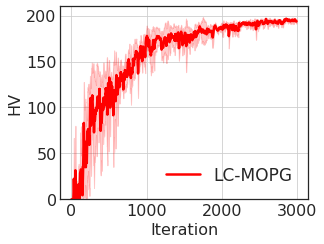

In [79]:
plt.figure(figsize=(4.6, 3.5))
#plt.xticks(np.arange(0, 501, 100))
plt.ylim(0, 210)
plt.tick_params(labelsize=16)
plt.grid()
plt.ylabel('HV', fontsize=16)
plt.xlabel('Iteration', fontsize=16)

w = 7
plt.plot(mv_avg(h_det.mean(axis=0), w=w), c='r', lw=2.5, label='LC-MOPG')
plt.fill_between(np.arange(3001 - w + 1), 
                 mv_avg(h_det.mean(axis=0) - h_det.std(axis=0), w=w), 
                 mv_avg(h_det.mean(axis=0) + h_det.std(axis=0), w=w),  
                 alpha=0.2, color='r')

plt.legend(fontsize=17)
plt.tight_layout()
# plt.savefig('learning_minecart.png', dpi=500)